<a href="https://colab.research.google.com/github/omriAR1/yolov3/blob/main/yoloV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yolo V3

Connect to drive and mount the folder.
The project is based on this path - 
/content/drive/MyDrive/AI/vision_proj/yolo_v3

please change your path accordingly.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/omriAR1/yolov3.git -o content/drive/MyDrive/AI/vision_proj/yolov3

fatal: destination path 'yolo_v3' already exists and is not an empty directory.


In [1]:
%cd '/content/drive/MyDrive/AI/vision_proj/yolo_v3'

/content/drive/MyDrive/AI/vision_proj/yolo_v3


The links might become inactive, I re-uploaded them today (28.2) to have maximum time left.
In case the wget command fails, please try downloading it in the browser and upload to the project base folder.

In [ ]:
#Download Yolo v3 weights
!wget 'https://mailmtaac-my.sharepoint.com/:u:/g/personal/omriar_mta_ac_il/EXQk2UwatlxCgCe-c_bjmhABJDSnE8T6fIMxipFHoRPV2Q?e=jbtAbp'
#Download Darknet53 weights
!wget 'https://mailmtaac-my.sharepoint.com/:u:/g/personal/omriar_mta_ac_il/Ec-xNGFBMnBNlVf8tuq4x3kBBohUKTTNncC5uBg4p_Z-XA?e=WUcwrn'

Run this command only if you are intrested in downloading data for training.
The data contains 83k images and is 19GB.

In [ ]:
%cd data
#Download COCO
!chmod 777 get_coco_dataset.sh
!./get_coco_dataset.sh

In [2]:
project_base_path = "/content/drive/MyDrive/AI/vision_proj/yolo_v3"

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os
import os.path as osp
import sys
import random
import re
import time
import torchvision
import cv2
import PIL
import matplotlib.pyplot as plt
import collections
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn


from boundingbox import BoundingBoxConverter, CoordinateType, FormatType
from tqdm import tqdm, tnrange, tqdm_notebook
from collections import OrderedDict
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
from torch import Tensor
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split, Subset
from torchvision import transforms, datasets, models
from mpl_toolkits.axes_grid1 import ImageGrid

sys.path.append(project_base_path)
from dataset import variable_shape_collate_fn
import boundingbox
import draw

In [4]:
CUDA = True
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
weight_path = f"{project_base_path}/yolov3.weights"
coco_path = f"{project_base_path}/coco.names"

In [5]:
def load_coco(path):
    with open(path) as f:
        return [line.rstrip("\n") for line in f.readlines()]
classes = load_coco(coco_path)

In [6]:
def letterbox_transforms(inner_dim, outer_dim):
    outer_w, outer_h = outer_dim
    inner_w, inner_h = inner_dim
    ratio = min(outer_w / inner_w, outer_h / inner_h)
    box_w = int(inner_w * ratio)
    box_h = int(inner_h * ratio)
    box_x_offset = (outer_w // 2) - (box_w // 2)
    box_y_offset = (outer_h // 2) - (box_h // 2)
    return box_w, box_h, box_x_offset, box_y_offset, ratio

def letterbox_image(img, dim):
    #Create the background
    image = np.full(dim +(3,), 128)
        
    img_dim = (img.shape[1], img.shape[0])
    box_w, box_h, box_x, box_y, ratio = letterbox_transforms(img_dim, dim)
    box_image = cv2.resize(img, (box_w,box_h), interpolation = cv2.INTER_CUBIC)
        
    #Put the box image on top of the blank image
    image[box_y:box_y+box_h, box_x:box_x+box_w] = box_image
        
    return image, (box_w, box_h, box_x, box_y, ratio)

# Mode - letterbox, resize
def load_image(img_path, mode=None, dim=None):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    trans = None
    if mode is not None and dim is not None:
        if mode == 'letterbox':
            img, trans = letterbox_image(img, dim)
        elif mode == 'resize':
            img = cv2.resize(img, dim)
    
    img = torch.from_numpy(img).float().permute(2,0,1) / 255
    return img, trans

# Define The NN building blocks

## Convulutional layer
based on -

[nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

[nn.BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)

[nn.LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html)

[nn.Upsample](https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html)

In [7]:
class conv_bn_relu(nn.Module):
    def __init__(self, nin, nout, ks, s=1, pad='SAME', padding=0, bn=True, act="leakyRelu"):
        super().__init__()
        
        self.bn = bn
        self.act = act
                
        if pad == 'SAME':
            padding = (ks - 1) // 2
            
        self.conv = nn.Conv2d(nin, nout, ks, s, padding, bias=not bn,device=device)
        if bn == True:
            self.bn = nn.BatchNorm2d(nout, device=device)
        if act == "leakyRelu":
            self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))
    
class res_layer(nn.Module):
    def __init__(self, nin):
        super().__init__()
        self.conv1 = conv_bn_relu(nin, nin//2, ks=1)
        self.conv2 = conv_bn_relu(nin//2, nin, ks=3)
        
    def forward(self, x):
        return x + self.conv2(self.conv1(x))


def map2cfgDict(mlist):
    idx = 0
    mdict = OrderedDict()
    for i,m in enumerate(mlist):
        if isinstance(m, res_layer):
            mdict[idx] = None
            mdict[idx+1] = None
            idx += 2
        mdict[idx] = i
        idx += 1
    return mdict


def make_res_stack(nin, num_blk):
    return nn.ModuleList([conv_bn_relu(nin, nin*2, 3, s=2)] \
           + [res_layer(nin*2) for n in range(num_blk)])

class Darknet(nn.Module):
    def __init__(self, blkList, nout=32):
        super().__init__()
        self.mlist = nn.ModuleList()
        self.mlist += [conv_bn_relu(3, nout, 3)]
        for i,nb in enumerate(blkList):
            self.mlist += make_res_stack(nout*(2**i), nb)
            
        self.map2yolocfg = map2cfgDict(self.mlist)
        self.cachedOutDict = dict()
        
    def forward(self,x):
        for i,m in enumerate(self.mlist):
            x = m(x)
            if i in self.cachedOutDict:
                self.cachedOutDict[i] = x
        return x

    def addCachedOut(self, idx, mode="yolocfg"):
        if mode == "yolocfg":
            idxs = self.map2yolocfg[idx]
        self.cachedOutDict[idxs] = None
        
    def getCachedOut(self, idx, mode="yolocfg"):
        if mode == "yolocfg":
            idxs = self.map2yolocfg[idx]
        return self.cachedOutDict[idxs]


class PreDetectionConvGroup(nn.Module):
    def __init__(self, nin, nout, num_conv=3, numClass=80):
        super().__init__()
        self.mlist = nn.ModuleList()
        
        for i in range(num_conv):
            self.mlist += [conv_bn_relu(nin, nout, ks=1)]
            self.mlist += [conv_bn_relu(nout, nout*2, ks=3)]
            if i == 0:
                nin = nout*2
                
        self.mlist += [nn.Conv2d(nin, (numClass+5)*3, 1)]
        self.map2yolocfg = map2cfgDict(self.mlist)
        self.cachedOutDict = dict()
        
    def forward(self,x):
        for i,m in enumerate(self.mlist):
            x = m(x)
            if i in self.cachedOutDict:
                self.cachedOutDict[i] = x
        return x

    def addCachedOut(self, idx, mode="yolocfg"):
        if mode == "yolocfg":
            idx = self.getIdxFromYoloIdx(idx)
        elif idx < 0:
            idx = len(self.mlist) - idx
        
        self.cachedOutDict[idx] = None

    def getCachedOut(self, idx, mode="yolocfg"):
        if mode == "yolocfg":
            idx = self.getIdxFromYoloIdx(idx)
        elif idx < 0:
            idx = len(self.mlist) - idx
        return self.cachedOutDict[idx]

    def getIdxFromYoloIdx(self,idx):
        if idx < 0:
            return len(self.map2yolocfg) + idx
        else:
            return self.map2yolocfg[idx]

class UpsampleGroup(nn.Module):
    def __init__(self, nin):
        super().__init__()
        self.conv = conv_bn_relu(nin, nin//2, ks=1)
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        
    def forward(self, route_head, route_tail):
        out = self.up(self.conv(route_head))
        return torch.cat((out, route_tail), 1)


class YoloLayer(nn.Module):
    def __init__(self, anchors, img_dim, numClass):
        super().__init__()
        self.anchors = anchors
        self.img_dim = img_dim
                
        self.numClass = numClass
        self.bbox_attrib = 5 + numClass
        
    def forward(self, x, img_dim):
        #x : bs x nA*(5 + num_classes) * h * w
        nB = x.shape[0]
        nA = len(self.anchors)
        nH, nW = x.shape[2], x.shape[3]
        stride = img_dim[1] / nH
        anchors = torch.FloatTensor(self.anchors) / stride
        
        #Reshape predictions from [B x [A * (5 + numClass)] x H x W] to [B x A x H x W x (5 + numClass)]
        preds = x.view(nB, nA, self.bbox_attrib, nH, nW).permute(0, 1, 3, 4, 2).contiguous()
        
        # tx, ty, tw, wh
        preds_xy = preds[..., :2]
        preds_wh = preds[..., 2:4]
        preds_conf = preds[..., 4].sigmoid()
        preds_cls = preds[..., 5:].sigmoid()
        
        # Calculate cx, cy, anchor mesh
        mesh_x = torch.arange(nW).repeat(nH,1).unsqueeze(2)
        mesh_y = torch.arange(nH).repeat(nW,1).t().unsqueeze(2)
        mesh_xy = torch.cat((mesh_x,mesh_y), 2)
        mesh_anchors = anchors.view(1, nA, 1, 1, 2).repeat(1, 1, nH, nW, 1)
        
        # pred_boxes holds bx,by,bw,bh
        pred_boxes = torch.FloatTensor(preds[..., :4].shape)
        pred_boxes[..., :2] = preds_xy.detach().cpu().sigmoid() + mesh_xy # sig(tx) + cx
        pred_boxes[..., 2:4] = preds_wh.detach().cpu().exp() * mesh_anchors  # exp(tw) * anchor
        
        # Return predictions if not training 
        out = torch.cat((pred_boxes.cuda() * stride, 
                         preds_conf.cuda().unsqueeze(4),
                         preds_cls.cuda() ), 4)
        
        # Reshape predictions from [B x A x H x W x (5 + numClass)] to [B x [A x H x W] x (5 + numClass)]
        # such that predictions at different strides could be concatenated on the same dimension
        out = out.permute(0, 2, 3, 1, 4).contiguous().view(nB, nA*nH*nW, self.bbox_attrib)
       
        return out


class YoloNet(nn.Module):
    def __init__(self, img_dim=None, anchors = [10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326], numClass=80):
        super().__init__()
        nin = 32
        self.numClass = numClass
        self.img_dim = img_dim
        self.stat_keys = ['loss', 'loss_x', 'loss_y', 'loss_w', 'loss_h', 'loss_conf', 'loss_cls',
                          'nCorrect', 'nGT', 'recall']
        
        anchors = [(anchors[i], anchors[i+1]) for i in range(0,len(anchors),2)]
        anchors = [anchors[i:i+3] for i in range(0, len(anchors), 3)][::-1]
                
        self.feature = Darknet([1,2,8,8,4])
        self.feature.addCachedOut(61)
        self.feature.addCachedOut(36)
        
        self.pre_det1 = PreDetectionConvGroup(1024, 512, numClass=self.numClass)
        self.yolo1 = YoloLayer(anchors[0], img_dim, self.numClass)
        self.pre_det1.addCachedOut(-3) #Fetch output from 4th layer backward including yolo layer
        
        self.up1 = UpsampleGroup(512)
        self.pre_det2 = PreDetectionConvGroup(768, 256, numClass=self.numClass)
        self.yolo2 = YoloLayer(anchors[1], img_dim, self.numClass)
        self.pre_det2.addCachedOut(-3)
        
        self.up2 = UpsampleGroup(256)
        self.pre_det3 = PreDetectionConvGroup(384, 128, numClass=self.numClass)
        self.yolo3 = YoloLayer(anchors[2], img_dim, self.numClass)
        
   
    def forward(self, x):
        img_dim = (x.shape[3], x.shape[2])
        #Extract features
        out = self.feature(x)
                
        #Detection layer 1
        out = self.pre_det1(out)
        det1 = self.yolo1(out, img_dim)
        
        #Upsample 1
        r_head1 = self.pre_det1.getCachedOut(-3)
        r_tail1 = self.feature.getCachedOut(61)
        out = self.up1(r_head1,r_tail1)
                
        #Detection layer 2
        out = self.pre_det2(out)
        det2 = self.yolo2(out, img_dim)
        
        #Upsample 2
        r_head2 = self.pre_det2.getCachedOut(-3)
        r_tail2 = self.feature.getCachedOut(36)
        out = self.up2(r_head2,r_tail2)
                
        #Detection layer 3
        out = self.pre_det3(out)
        det3 = self.yolo3(out, img_dim)
        
        return det1, det2, det3
    
    # Format : pytorch / darknet
    def saveWeight(self, weights_path, format='pytorch'):
        if format == 'pytorch':
            torch.save(self.state_dict(), weights_path)
        elif format == 'darknet':
            raise NotImplementedError
    
    def loadWeight(self, weights_path, format='pytorch'):
        if format == 'pytorch':
            weights = torch.load(weights_path, map_location=lambda storage, loc: storage)
            self.load_state_dict(weights)
        elif format == 'darknet':
            wm = WeightManager(self)
            wm.loadWeight(weights_path)

In [8]:
class WeightManager:
    def __init__(self, model):
        super().__init__()
        self.conv_list = self.find_conv_layers(model)

    def loadWeight(self, weight_path):
        ptr = 0
        weights = self.read_file(weight_path)
        #print(len(weights))
        for m in self.conv_list:
            if type(m) == conv_bn_relu:
                ptr = self.load_conv_bn_relu(m, weights, ptr)
            elif type(m) == nn.Conv2d:
                ptr = self.load_conv2D(m, weights, ptr)
        return ptr
                
    def read_file(self, file):
        with open(file, "rb") as fp:
            header = np.fromfile(fp, dtype = np.int32, count = 5)
            self.header = torch.from_numpy(header)
            self.seen = self.header[3]
            weights = np.fromfile(fp, dtype = np.float32)
        return weights
    
    def copy_weight_to_model_parameters(self, param, weights, ptr):
        num_el = param.numel()
        param.data.copy_(torch.from_numpy(weights[ptr:ptr + num_el])
                             .view_as(param.data))
        return ptr + num_el
    
    def load_conv_bn_relu(self, m, weights, ptr):
        ptr = self.copy_weight_to_model_parameters(m.bn.bias, weights, ptr)
        ptr = self.copy_weight_to_model_parameters(m.bn.weight, weights, ptr)
        ptr = self.copy_weight_to_model_parameters(m.bn.running_mean, weights, ptr)
        ptr = self.copy_weight_to_model_parameters(m.bn.running_var, weights, ptr)
        ptr = self.copy_weight_to_model_parameters(m.conv.weight, weights, ptr)
        return ptr
        
    def load_conv2D(self, m, weights, ptr):
        ptr = self.copy_weight_to_model_parameters(m.bias, weights, ptr)
        ptr = self.copy_weight_to_model_parameters(m.weight, weights, ptr)
        return ptr
        
    def find_conv_layers(self, mod):
        module_list = []
        for m in mod.children():
            if type(m) == conv_bn_relu:
                module_list += [m]
            elif type(m) == nn.Conv2d:
                module_list += [m]
            elif isinstance(m, (nn.ModuleList, nn.Module)):
                module_list += self.find_conv_layers(m)
            elif type(m) == res_layer:
                module_list += self.find_conv_layers(m)
        return module_list


### Loads the pre tained weight and initialze the weights

In [9]:
net = YoloNet().to(device).eval()
net.loadWeight(weight_path, format='darknet')
imglist = os.listdir(f"{project_base_path}/imgs")
for i,img in enumerate(imglist):
    print('{}: {}'.format(i,img))

0: cup1.jpg
1: dog-cycle-car.png
2: eagle.jpg
3: traffic.jpeg


In [10]:
img_path = f"{project_base_path}/imgs/{imglist[0]}"
resolution = 416
testData, trans = load_image(img_path, mode='letterbox', dim=(resolution, resolution))
testData = testData.unsqueeze(0).to(device)
det1,det2,det3 = net(testData)

det1.shape,det2.shape,det3.shape

(torch.Size([1, 507, 85]),
 torch.Size([1, 2028, 85]),
 torch.Size([1, 8112, 85]))

In [11]:
def bbox_plt(box):
    bx, by = box[0], box[1]
    bw = box[2] - box[0]
    bh = box[3] - box[1]
    return [bx, by, bw, bh]

def show_output(img, dets):
    ax = draw.show_img(img, figsize=(16,8))
    for d in dets:
        d = d.detach()
        draw.draw_rect(ax, bbox_plt(d))
        c = classes[d[-1].int().item()]
        draw.draw_text(ax, d[:2], c)

def torch_unique(inp, CUDA=True):
    if CUDA:
        inp_cpu = inp.detach().cpu()
    
    res_cpu = torch.unique(inp_cpu)
    res = inp.new(res_cpu.shape)
    res.copy_(res_cpu)
  
    return res
    
def unqiue_with_order(inp, CUDA=True):
    if CUDA:
        inp_np = inp.detach().cpu().numpy()
    
    _, idx = np.unique(inp, return_index=True)
    result = inp_np[np.sort(idx)]
    result_tensor = torch.from_numpy(result)
    res = inp.new(result_tensor.shape)
    res.copy_(result_tensor)
    return res


def iou_vectorized(bbox):
    num_box = bbox.shape[0]
    
    bbox_leftTop_x =  bbox[:,0]
    bbox_leftTop_y =  bbox[:,1]
    bbox_rightBottom_x = bbox[:,2]
    bbox_rightBottom_y = bbox[:,3]
    
    inter_leftTop_x     =  torch.max(bbox_leftTop_x.unsqueeze(1).repeat(1,num_box), bbox_leftTop_x)
    inter_leftTop_y     =  torch.max(bbox_leftTop_y.unsqueeze(1).repeat(1,num_box), bbox_leftTop_y)
    inter_rightBottom_x =  torch.min(bbox_rightBottom_x.unsqueeze(1).repeat(1,num_box), bbox_rightBottom_x)
    inter_rightBottom_y =  torch.min(bbox_rightBottom_y.unsqueeze(1).repeat(1,num_box), bbox_rightBottom_y)
    
    inter_area = torch.clamp(inter_rightBottom_x - inter_leftTop_x, min=0) * torch.clamp(inter_rightBottom_y - inter_leftTop_y, min=0)
    bbox_area = (bbox_rightBottom_x - bbox_leftTop_x) * (bbox_rightBottom_y - bbox_leftTop_y)
    union_area = bbox_area.expand(num_box,-1) + bbox_area.expand(num_box,-1).transpose(0, 1) - inter_area
    
    iou = inter_area / union_area
    return iou

#Iterate through the bounding boxes and remove rows accordingly
def reduce_row_by_column(inp):
    i = 0
    while i < inp.shape[0]:
        remove_row_idx = inp[i][1].item()
        if inp[i][0] != remove_row_idx and i < inp.shape[0]:
            keep_mask = (inp[:,0] != remove_row_idx).nonzero().squeeze()
            inp = inp[keep_mask]
        i += 1
    return inp

#bbox is expected to be sorted by class score in descending order
def nms(bbox, iou, nms_thres):
    #Create a mapping that indicates which row has iou > threshold
    remove_map = (iou > nms_thres).nonzero()
    remove_map = reduce_row_by_column(remove_map)
    
    remove_idx = torch_unique(remove_map[:,0])
    res_bbox = bbox[remove_idx]
    
    return res_bbox


def postprocessing(detections, num_classes, obj_conf_thr=0.5, nms_thr=0.4):
    #Zero bounding box with objectioness confidence score less than threshold 
    obj_conf_filter = (detections[:,:,4] > obj_conf_thr).float().unsqueeze(2)
    detections = detections * obj_conf_filter
           
    #Transform bounding box coordinates to two corners
    box = detections.new(detections[:,:,:4].shape)
    box[:,:,0] = detections[:,:,0] - detections[:,:,2]/2
    box[:,:,1] = detections[:,:,1] - detections[:,:,3]/2
    box[:,:,2] = box[:,:,0] + detections[:,:,2]
    box[:,:,3] = box[:,:,1] + detections[:,:,3]
    detections[:,:,:4] = box
    
    num_batches = detections.shape[0]
    #results = torch.Tensor().to(device)
    results = list()
        
    for b in range(num_batches):
        batch_results = torch.Tensor().cuda()
        img_det = detections[b]
        	
        
        max_class_score, max_class_idx= torch.max(img_det[:,5:5 + num_classes], 1)
        img_det = torch.cat((img_det[:,:5],
                             max_class_score.float().unsqueeze(1),
                             max_class_idx.float().unsqueeze(1)
                            ), 1)
        #img det - [b1_x, b1_y, b2_x, b2_y, obj_conf, class_score, class]
        
        #Remove zeroed rows
        nonzero_idx =  img_det[:,4].nonzero()
        img_det = img_det[nonzero_idx,:].view(-1,7)
               
        if img_det.shape[0] == 0:
            results.append(batch_results.cpu())
        else:
            #Get the classes
            img_classes = torch_unique(img_det[:,-1])
            for c in img_classes:
                # Select rows with "c" class and sort by the class score
                class_img_det = img_det[(img_det[:,-1] == c).nonzero().squeeze()]
                # If there is only one detection, it will return a 1D tensor. Therefore, we perform a view to keep it in 2D
                class_img_det = class_img_det.view(-1, 7)
                #Sort by objectness score
                _, sort_idx = class_img_det[:,4].sort(descending=True)
                class_img_det = class_img_det[sort_idx]

                iou = iou_vectorized(class_img_det)
                #Alert: There's another loop operation in nms function
                class_img_det = nms(class_img_det, iou, nms_thr)
                batch_results = torch.cat((batch_results, class_img_det), 0)

            results.append(batch_results.cpu())
    
    return results

In [12]:
detections = torch.cat((det1,det2,det3), 1)
pdet = postprocessing(detections, 80, obj_conf_thr=0.5)

/content/drive/MyDrive/AI/vision_proj/yolo_v3/draw.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(im).cpu()


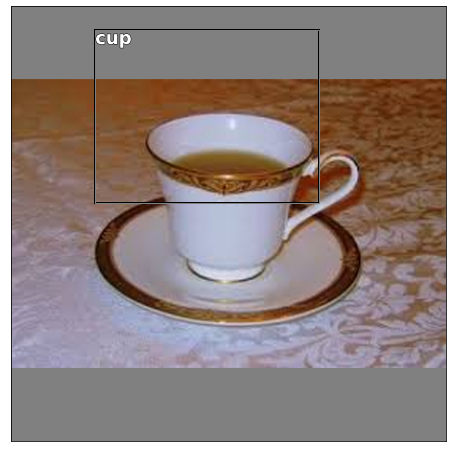

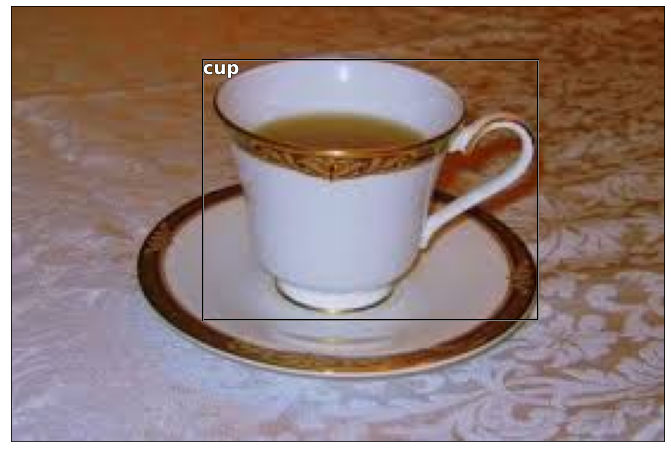

In [13]:
show_output(testData.squeeze(0).permute(1,2,0), pdet[0])
#load the original image with no letterbox
img, _ = load_image(f"{project_base_path}/imgs/{imglist[0]}")
img = img.permute(1,2,0)

def bbox_transform(box, x_max, y_max, x_offset, y_offset, ratio):
    box[:,[0,2]] = torch.clamp((box[:,[0,2]] - x_offset) / ratio, 0, x_max)
    box[:,[1,3]] = torch.clamp((box[:,[1,3]] - y_offset) / ratio, 0, y_max)
    return box

#trans is returned from the load_image call when we first input the letterboxed image into the network
box = pdet[0][:, :4]
box = bbox_transform(box, img.shape[1], img.shape[0], *trans[-3:])
box
show_output(img, pdet[0])


In [14]:
class ImageFolderDataset(Dataset):
    def __init__(self, img_dir, transforms=None):
        self.img_dir = img_dir
        self.transforms = transforms
        
        self.img_list = os.listdir(img_dir)
        
    def __getitem__(self, idx):
        img_path = osp.join(self.img_dir, self.img_list[idx])
        if osp.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), img_path)
            
        org_img = img.copy()        
        
        img, lb_params = letterbox_image(img, dim)
        image_torch = torch.from_numpy(img).float()
        image_torch= image_torch.to(device)
        img = image_torch.permute(2,0,1) / 255
        org_img_torch = torch.from_numpy(org_img).float()
        org_img_torch = org_img_torch.to(device)
        org_img = org_img_torch.permute(2,0,1) / 255
        lb_params = torch.Tensor(lb_params).float().to(device)
        
        sample = { 'img': img, 'org_img': org_img, 'lb_params':lb_params }    
        return sample
    
    def __len__(self):
        return len(self.img_list)
bs = 4
sz = 416
dim = (sz, sz)

nImgShow  = 4
start_idx = 0
end_idx = start_idx + nImgShow
dataset_subset_idx = np.arange(start_idx, end_idx)
img_dataset = ImageFolderDataset(f"{project_base_path}/imgs/", trans)
img_dataset = Subset(img_dataset, dataset_subset_idx)

# variable_shape_collate_fn
# It's a function responisble for stacking samples into batches.
# By default, it doesn't allow users to output tensors with different shapes.
# "variable_shape_collate_fn" here will collect these tensors into a list if they have inconsistent dimensions
# which is used by 'org_img' since the images will have different width and height before they are letterboxed.
# Try disabling it and it will raise an error in collate_fn. Detail code will be later notebooks.


img_dataloader = DataLoader(img_dataset, batch_size=8, collate_fn=variable_shape_collate_fn)

for sample in img_dataloader:
    print(sample['img'].shape)
    print([o.shape for o in sample['org_img']])
    print(sample['lb_params'])


def bbox_transform(box, x_max, y_max, x_offset, y_offset, ratio):
    box[...,[0,2]] = torch.clamp((box[...,[0,2]] - x_offset) / ratio, 0, x_max)
    box[...,[1,3]] = torch.clamp((box[...,[1,3]] - y_offset) / ratio, 0, y_max)
    return box

def fill_label_np_tensor(label, row, col):
    label_tmp = np.full((row, col), 0.0)
    if label is not None and len(label) != 0 :
        length = label.shape[0] if label.shape[0] < row else row
        label_tmp[:length] = label[:length]
    return label_tmp

def prep_img_for_plt(img_list):
    if isinstance(img_list, collections.abc.Sequence):
        img_list = [img.permute(1,2,0).numpy() for img in img_list] 
    else:
        img_list = img_list.permute(0,2,3,1).numpy()
    return img_list

def prep_predictions_for_plt(preds_list, img_list, lb_params_list, reverse_letterbox):
    preds_list = Tensor([fill_label_np_tensor(p.numpy(), 50, 7) for p in preds_list])
    # cls,x1,y1,x2,y2
    preds_list = preds_list[..., [6, 0, 1, 2, 3,]]

    if reverse_letterbox:
        for b_idx, (preds, img, lb_param) in enumerate(zip(preds_list, img_list, lb_params_list)):
            dim = img.shape[1], img.shape[0]
            x_offset, y_offset, ratio = lb_param[-3], lb_param[-2], lb_param[-1]
            for i, prow in enumerate(preds):    
                prow = bbox_transform(prow[1:5], dim[0], dim[1], x_offset, y_offset, ratio)

    preds_list[..., 1:5] =  boundingbox.bbox_x1y1x2y2_to_xywh(preds_list[..., 1:5])
    preds_list = preds_list.numpy()
    return preds_list

def predict(data, net, num_classes=80, reverse_letterbox=True):
    img_list = []
    preds_list = []
    lb_params_list = torch.FloatTensor().to(device)
    with torch.no_grad(): 
        for sample in data:
            imgs, org_imgs, lb_params = sample['img'].cuda(), sample['org_img'], sample['lb_params']
            dim = (imgs.shape[3], imgs.shape[2])

            lb_params_list = torch.cat((lb_params_list, lb_params), 0)
            # Copy original image instead of the letterboxed image
            if reverse_letterbox:                      
                img_list += [img.cpu() for img in org_imgs]
            else:
                img_list += [img for img in imgs.cpu()]
            
            # Pass images to the network
            det1, det2, det3 = net(imgs)
            predictions = postprocessing(torch.cat((det1,det2,det3), 1), num_classes, obj_conf_thr=0.5, nms_thr=0.4)
            preds_list += predictions

        img_list = prep_img_for_plt(img_list)
        preds_list = prep_predictions_for_plt(preds_list, img_list, lb_params_list, reverse_letterbox)
    return img_list, preds_list

img_list, preds_list = predict(img_dataloader, net, reverse_letterbox=False)
print('img_list shape: {}'.format([i.shape for i in img_list]))
print('preds_list shape: {}'.format([p.shape for p in preds_list]))

torch.Size([4, 3, 416, 416])
[torch.Size([3, 183, 275]), torch.Size([3, 452, 602]), torch.Size([3, 512, 773]), torch.Size([3, 773, 1200])]
tensor([[4.1600e+02, 2.7600e+02, 0.0000e+00, 7.0000e+01, 1.5127e+00],
        [4.1600e+02, 3.1200e+02, 0.0000e+00, 5.2000e+01, 6.9103e-01],
        [4.1500e+02, 2.7500e+02, 1.0000e+00, 7.1000e+01, 5.3816e-01],
        [4.1600e+02, 2.6700e+02, 0.0000e+00, 7.5000e+01, 3.4667e-01]],
       device='cuda:0')
img_list shape: [(416, 416, 3), (416, 416, 3), (416, 416, 3), (416, 416, 3)]
preds_list shape: [(50, 5), (50, 5), (50, 5), (50, 5)]


<ipython-input-14-c04da6d8bb66>:79: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  preds_list = Tensor([fill_label_np_tensor(p.numpy(), 50, 7) for p in preds_list])


## Checking the model prediction on validation data

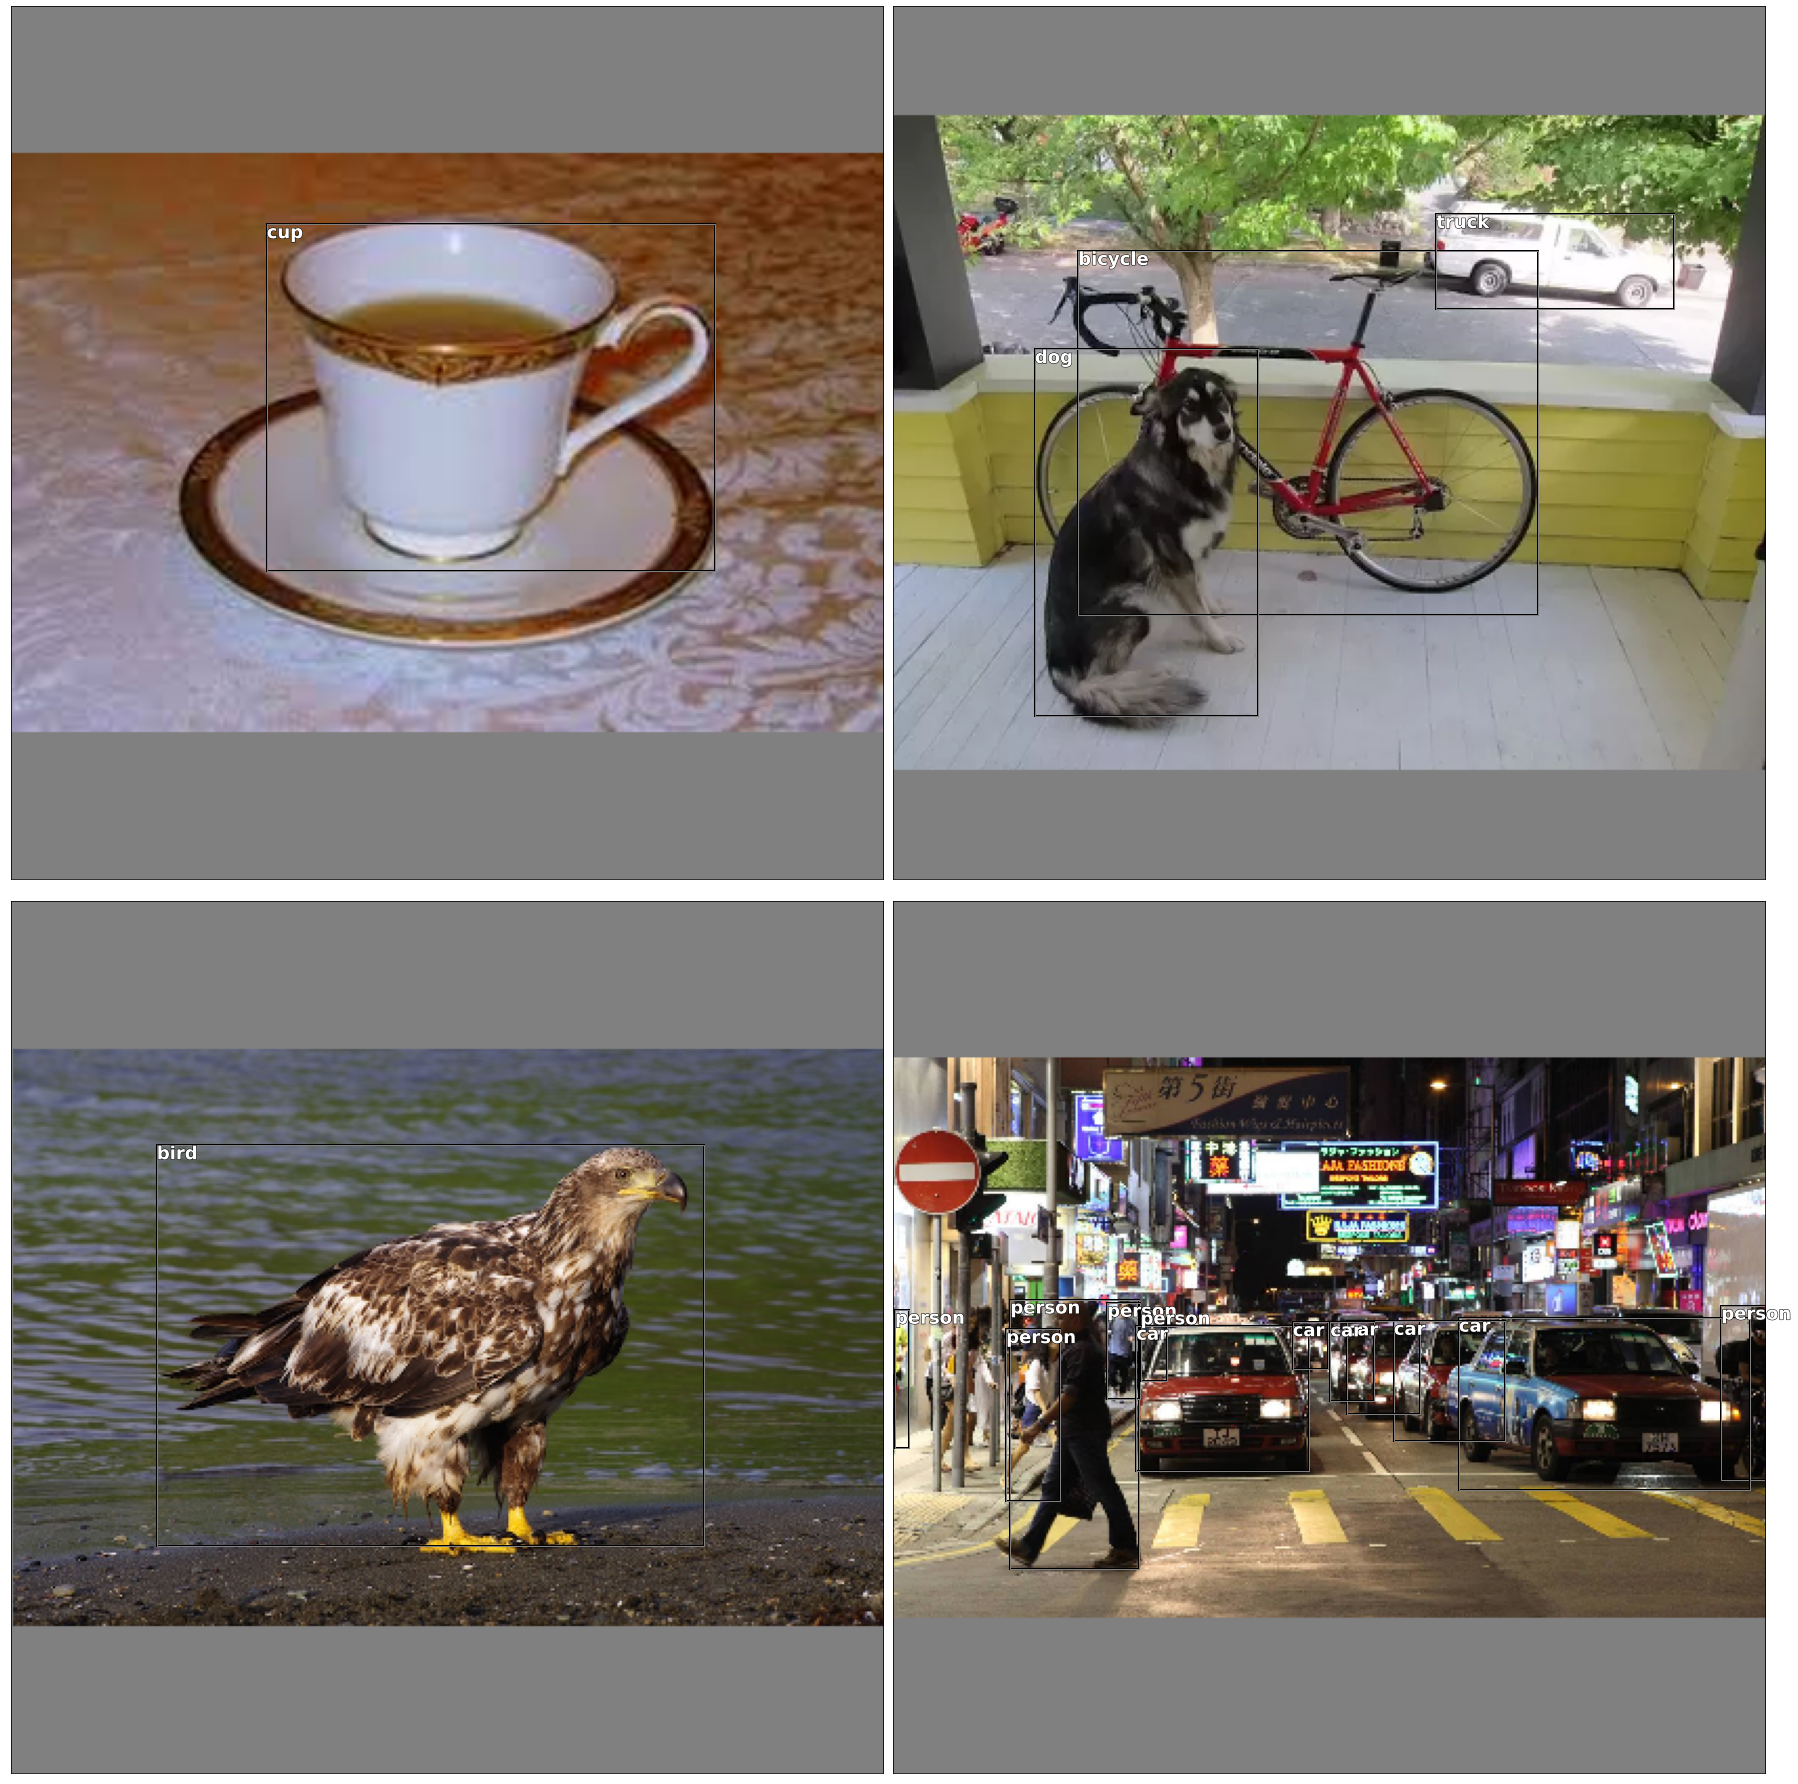

In [15]:
def draw_axis(ax, isDraw=False):
    ax.get_xaxis().set_visible(isDraw)
    ax.get_yaxis().set_visible(isDraw)

def draw_image(ax, img):
    ax.imshow(img,  aspect='equal')

def draw_labels(ax, labels, classes, coord_idx=[1,2,3,4], class_idx=0):
    for l in labels:
        if l.sum() == 0:
            continue
        rect = l[coord_idx]
        draw.draw_rect(ax, rect)
        c = classes[l[class_idx].astype(np.int32)]
        draw.draw_text(ax, rect[:2], c)
        
# Display a list of images with labels in given grid size         
def show_img_grid(img_list, classes=None,
                  labels_list=None, coord_idx=[1,2,3,4], class_idx=0,
                  cols=2, figsize=None, col_title_dict=None):
    results = []
    rows = int(np.ceil(len(img_list) / cols))

    heights = [a.shape[0] for a in img_list[::cols]]
    widths = [a.shape[1] for a in img_list[0:cols]]

    fig_width = 25  # inches
    fig_height = fig_width * sum(heights) / sum(widths)
    fig_size = (fig_width, fig_height)

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=fig_size, gridspec_kw={'height_ratios':heights})
    axes = [ax for ax in axes.ravel()]

    if col_title_dict is not None:
        assert(cols == len(col_title_dict['title']))
        for ax, col in zip(axes[:cols], col_title_dict['title']):
            ax.set_title(col, pad=col_title_dict['pad'], 
                         fontdict={'fontsize': col_title_dict['fontsize'],
                                   'fontweight' : col_title_dict['fontweight'] })
    
    if labels_list is None:
        labels_list = []

    for ax, img, labels in itertools.zip_longest(axes, img_list, labels_list, fillvalue=None):
        if img is not None:
            draw_image(ax, img)
        if labels is not None:
            draw_labels(ax, labels, classes, coord_idx=coord_idx, class_idx=class_idx)
        draw_axis(ax, False)


    plt.subplots_adjust(wspace=0.01, hspace=0.02, left=0, right=1, bottom=0, top=1)
    plt.tight_layout()

show_img_grid(img_list, cols=2, classes=classes, labels_list=preds_list)

## Viewing the net internal organs
Running the following command will results in printing each layer, with its configuration.

In [30]:
print(net)

YoloNet(
  (feature): Darknet(
    (mlist): ModuleList(
      (0): conv_bn_relu(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (1): conv_bn_relu(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (2): res_layer(
        (conv1): conv_bn_relu(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): LeakyReLU(negative_slope=0.1, inplace=True)
        )
        (conv2): conv_bn_relu(
          (conv): Conv2d(32, 64, kernel_size=(3, 3)

# Video input & output

## reading video input
Save each frame in a directory

In [24]:
!mkdir "/content/video_input"
!mkdir "/content/video_input_images"
!mkdir "/content/video_output"

mkdir: cannot create directory ‘/content/video_input’: File exists
mkdir: cannot create directory ‘/content/video_input_images’: File exists


In [20]:
def frames_from_video(video_filename):
    video = cv2.VideoCapture(video_filename)
    success, image = video.read()
    frames = []
    while success:
        success, image = video.read()
        try:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            resized = cv2.resize(image, (416, 416), interpolation = cv2.INTER_AREA)
            frames.append(resized)
        except Exception as ex:
            print(ex)
            continue
    video.release()
    cv2.destroyAllWindows()
    # delete every krd element
    del frames[3 - 1::3]
    return frames

def save_all_frames_to_file(frame_list, file_path):
  for frame_index, frame in enumerate(frame_list):
    cv2.imwrite(f"{file_path}/{frame_index}.jpg", frame)


frames = frames_from_video("/content/video_input/was_a_good_day.mov")
save_all_frames_to_file(frames, "/content/video_input_images")

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



## Create a dataset from the video images

In [21]:
start_idx = 0
onlyfiles = next(os.walk("/content/video_input_images/"))[2]
dataset_subset_idx = np.arange(start_idx, len(onlyfiles))

img_dataset = ImageFolderDataset("/content/video_input_images/", None)
img_dataset = Subset(img_dataset, dataset_subset_idx)

img_dataloader = DataLoader(img_dataset, batch_size=8, collate_fn=variable_shape_collate_fn)

img_list, preds_list = predict(img_dataloader, net, reverse_letterbox=False)
print(f"img_list length: {len(img_list)}")
print(f"preds_list length: {len(preds_list)}")

img_list length: 1080
preds_list length: 1080


Using the test function to control the output.
Technical issue - have a function that draw the lavbels and the text on the image instead of saving each image as figure and saving it to file

In [26]:
# Display a list of images with labels in given grid size         
def show_img_grid_lazy(img_list, classes=None,
                  labels_list=None, coord_idx=[1,2,3,4], class_idx=0,
                  cols=2, figsize=None, col_title_dict=None, file_name=None):
    results = []
    rows = 1

    heights = [a.shape[0] for a in img_list[::cols]]
    widths = [a.shape[1] for a in img_list[0:cols]]

    fig_width = 20  # inches
    fig_height = fig_width * sum(heights) / sum(widths)
    fig_size = (fig_width, fig_height)

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=fig_size, gridspec_kw={'height_ratios':heights})
    axes = np.array(axes)
    axes = [ax for ax in axes.ravel()]

    if col_title_dict is not None:
        assert(cols == len(col_title_dict['title']))
        for ax, col in zip(axes[:cols], col_title_dict['title']):
            ax.set_title(col, pad=col_title_dict['pad'], 
                         fontdict={'fontsize': col_title_dict['fontsize'],
                                   'fontweight' : col_title_dict['fontweight'] })
    
    if labels_list is None:
        labels_list = []

    for ax, img, labels in itertools.zip_longest(axes, img_list, labels_list, fillvalue=None):
        if img is not None:
            draw_image(ax, img)
        if labels is not None:
            draw_labels(ax, labels, classes, coord_idx=coord_idx, class_idx=class_idx)
        draw_axis(ax, False)
    plt.savefig(file_name)
    plt.close(fig)

    return fig

In [ ]:
for index, image in enumerate(img_list):
  show_img_grid_lazy([img_list[index]], cols=1, classes=classes, labels_list=[preds_list[index]], file_name=f"/content/video_output/{index}.jpg")


Note the the video output is to the root folder for collab, its done this way to avoid slow and costly sync with google drive

In [29]:
def create_video_from_images(input_folder, output_file_name="/content/object_detection.avi"):
    size = (416, 416)
    fps = 20
    fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')

    out = cv2.VideoWriter(output_file_name, fourcc, fps, size, isColor=True)

    image_files = next(os.walk(f"{input_folder}/"))[2]
    image_files.sort()

    for processed_image_path in image_files:
        out_frame = cv2.imread(f"{input_folder}/{processed_image_path}")
        img = cv2.resize(out_frame, size)
        frame = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        out.write(frame)

    out.release()

create_video_from_images("/content/video_output")

Sneak peak into our video

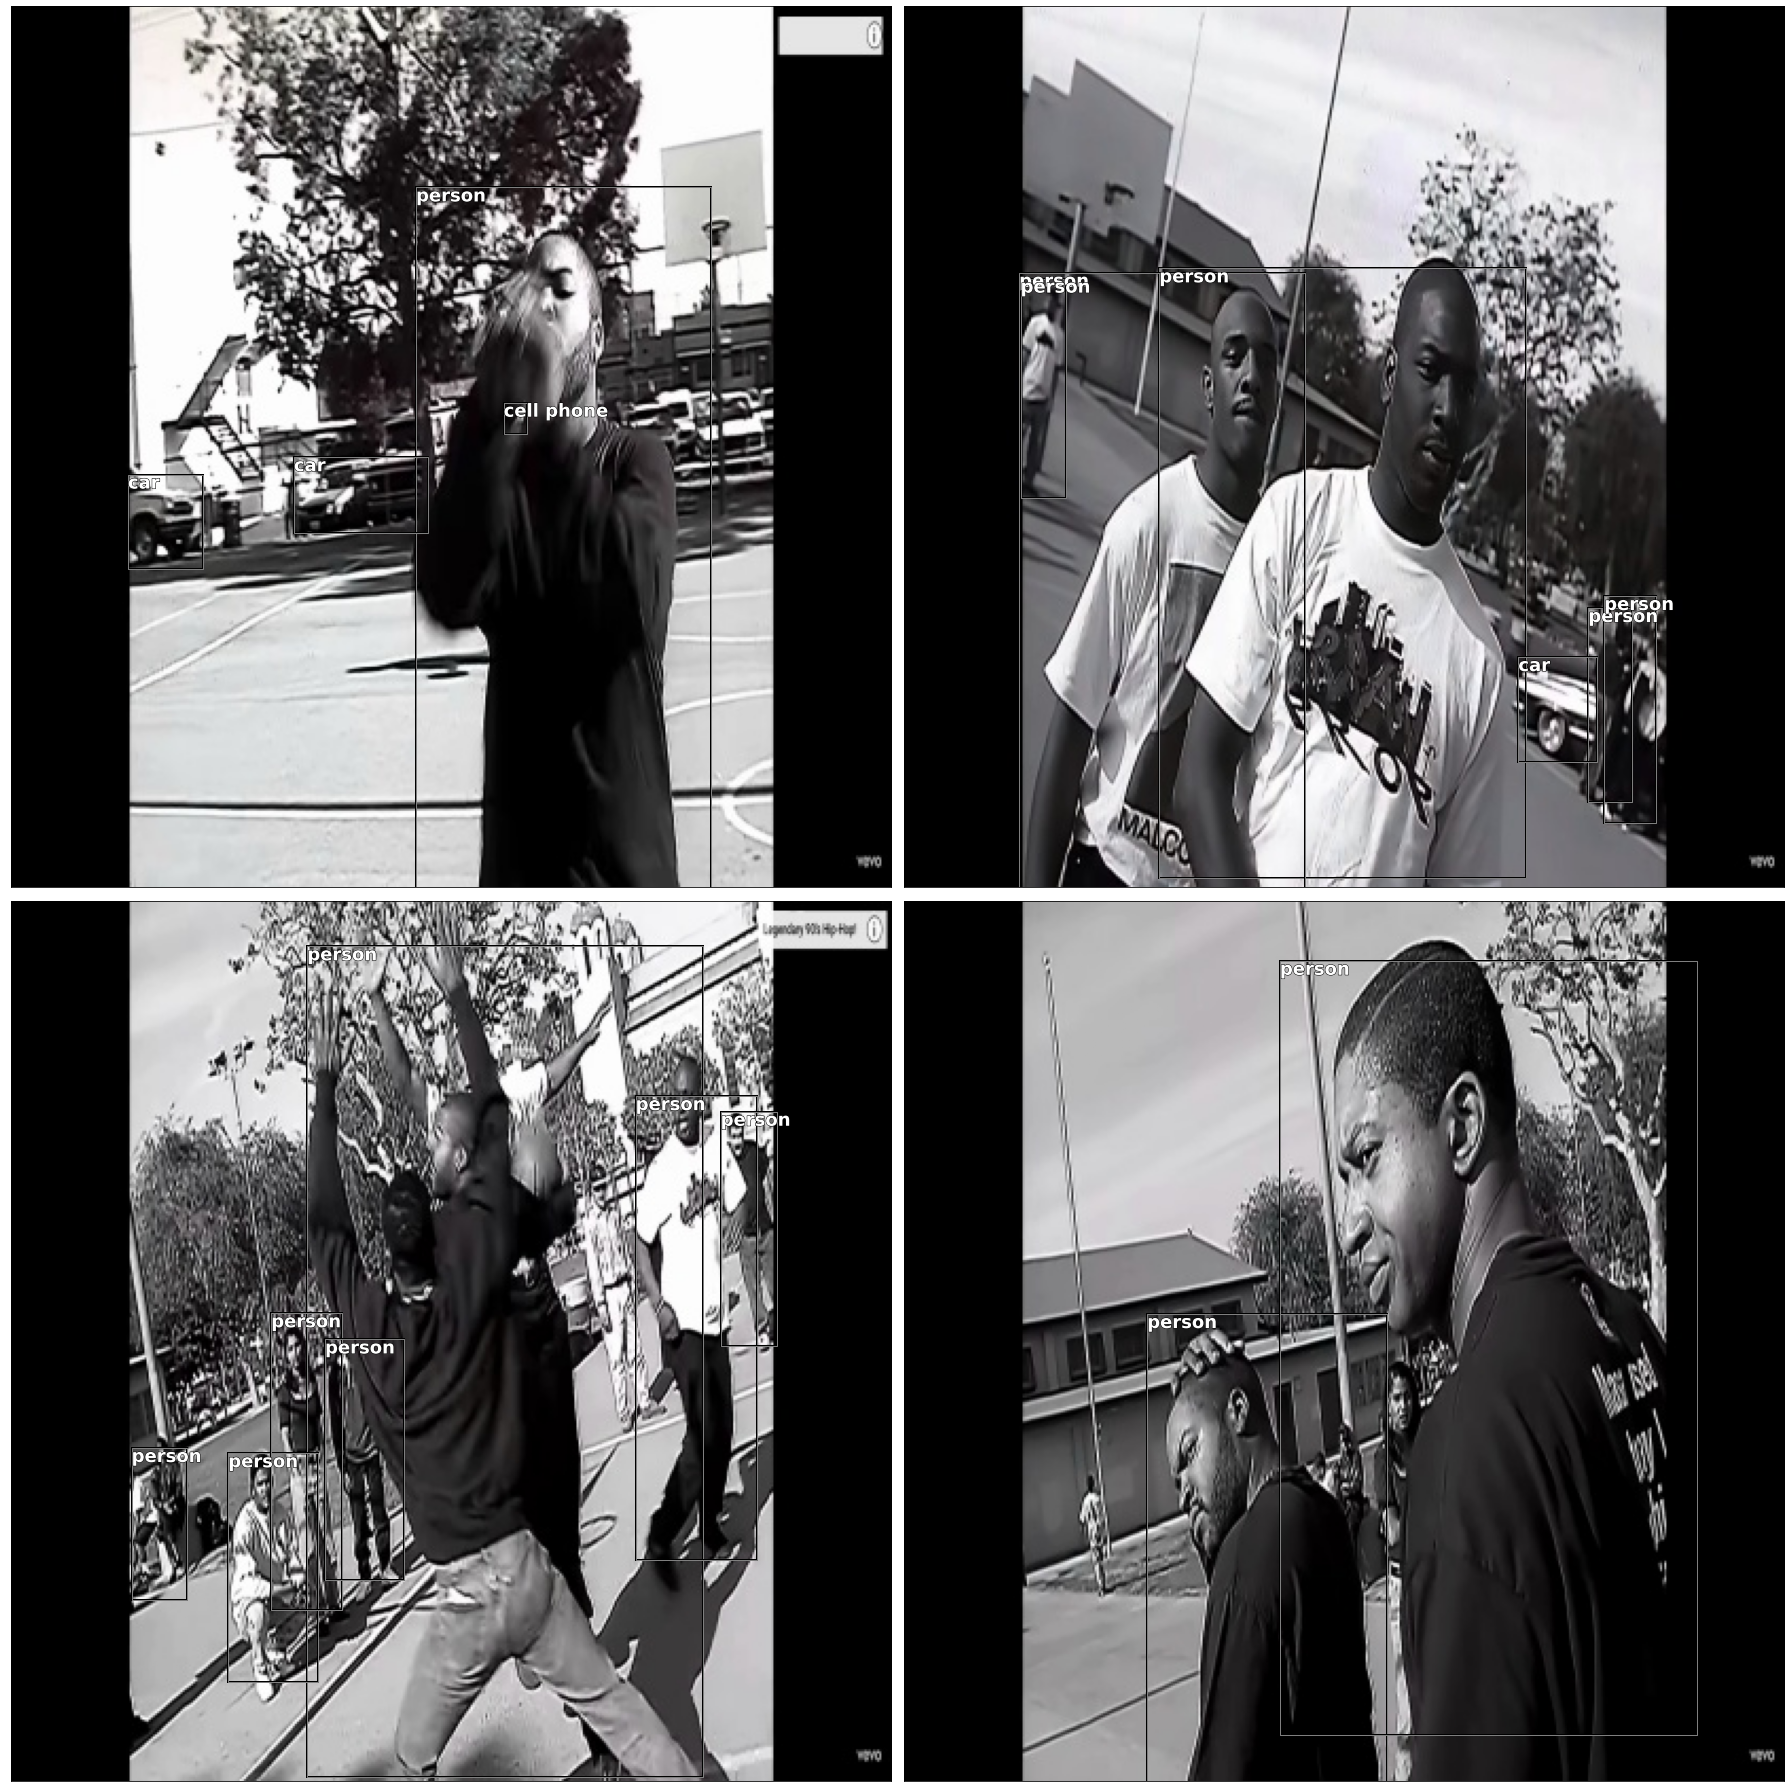

In [30]:
show_img_grid(img_list[:4], cols=2, classes=classes, labels_list=preds_list[:4])

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import imgaug as ia


from collections import OrderedDict

from lxml import etree
from imgaug import augmenters as iaa

from utils import letterbox_label_reverse
from transforms import IaaAugmentations, IaaLetterbox, ToTensor, Compose, \
                       iaa_hsv_aug, iaa_random_crop, iaa_letterbox
from dataset import COCODataset, ImageFolderDataset, DataHelper
from dataset import worker_init_fn, variable_shape_collate_fn

from test import *
from train import *

seed = 0

def set_seed(seed):
    cudnn.benchmark = False
    cudnn.deterministic = True

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    

set_seed(seed)
#Paths

backbone_weight_path = '/content/drive/MyDrive/AI/vision_proj/yolo_v3/darknet53.conv.74'
train_target_txt = "/content/data/data/coco/trainvalno5k.txt"
valid_target_txt = "/content/dara/data/coco/5k.txt"
cv2.setNumThreads(0)

def load_coco(path):
    with open(path) as f:
        return [line.rstrip("\n") for line in f.readlines()]

def getTransforms(dim, aug=True):
    if aug:
        transform = Compose([IaaAugmentations([iaa_hsv_aug(0.1, 1.5, 1.5),
                                               iaa_random_crop(0.3),
                                               iaa.Fliplr(0.5),
                                               iaa.Scale(dim)
                                              ]),
                             ToTensor()])
    else:
        transform = Compose([IaaAugmentations([iaa.Scale(dim)
                                              ]),
                             ToTensor()])
    return transform

def get_trans_fn(aug):
    def getTransformByDim(dim):
        return getTransforms(dim, aug)
    return getTransformByDim


def getCOCOData(seed, train_target_txt, bs, aug=True, subset_idx=None, 
                shuffle=True, cyclic=True, dim=None, rand_dim_interval=None,
                max_net_batches=None, net_subdivisions=1):
  
    torch.manual_seed(seed)
    trans_fn = lambda dim: getTransforms(dim, aug)
    coco_ds = COCODataset(train_target_txt, bs, subset_idx=subset_idx, 
                          trans_fn=trans_fn, shuffle=shuffle, cyclic=cyclic, 
                          dim=dim, rand_dim_interval=rand_dim_interval)
    coco_dl = DataLoader(coco_ds, batch_size=bs, shuffle=False, num_workers=4, 
                         worker_init_fn=worker_init_fn, 
                         collate_fn=variable_shape_collate_fn)
    coco_data = DataHelper(coco_ds, coco_dl, current_batch=0, 
                           max_net_batches=max_net_batches, 
                           net_subdivisions=net_subdivisions)
    return coco_data


# Optimizer parameters
ratio = 1
lr = 0.001 / ratio
backbone_lr = 0.001 / ratio
momentum = 0.9
wd = 0.0005
freeze_backbone = False

# Network paramters. Increase subdivisions if GPU don't have enough memory
net_bs = 64
net_subdivisions = 8
bs = int(net_bs / net_subdivisions)

# Change image dimension every 10 net_batch -> 40 mini-batch
random_dim_interval = net_bs * 10

# Save interval in units of net batch
checkpoint_interval = 100 #100

# Maximum net batches to train, roughly around 270 epochs
max_net_batches = 500200 # 500200
model_id = 'COCO_ydixon'
weight_dir = './weights'

#remove_checkpoints(model_id, weight_dir)

net = YoloNet((sz, sz)).cuda()
net.feature.loadWeight(backbone_weight_path) # Load backbone darknet53 weight
#net.loadWeight(pt_weight_path) # Load pretrained pytorch weight
#net.loadWeight(weight_path, 'darknet') # Load full yolo v3 weight
#net.load_state_dict(old_checkpoint['net']) # Load state_dict from older versions of checkpoints

data = getCOCOData(seed, train_target_txt, bs, aug=True,
                   subset_idx=None, shuffle=True, cyclic=True, dim=None, rand_dim_interval=random_dim_interval,
                   max_net_batches=max_net_batches, net_subdivisions=net_subdivisions)
optimizer = get_optimizer(net, lr, backbone_lr, wd, momentum, freeze_backbone)
recorder = Recorder()


train(data, net, optimizer, recorder,
      model_id=model_id, weight_dir=weight_dir,
      checkpoint=None, checkpoint_interval=checkpoint_interval,
      use_gpu=True)   

def resume_training(max_net_batches, model_id, weight_dir):
    checkpoint_path, latest_epoch = get_latest_checkpoint(model_id, weight_dir)
    #checkpoint_path='./weights/COCO_rand_4/yolov3_COCO_rand_4_checkpoint_000099.pth.tar'

    if checkpoint_path is None:
        print('No checkpoint for %s found' % model_id)
        return
    
    print('Loading %s' % checkpoint_path)
    checkpoint = load_checkpoint(checkpoint_path)
    
    data = getCOCOData(seed, train_target_txt, bs, aug=True,
                       subset_idx=None, shuffle=True, cyclic=True, dim=None, 
                       rand_dim_interval=random_dim_interval,
                       max_net_batches=max_net_batches, 
                       net_subdivisions=net_subdivisions)

    net = YoloNet((sz, sz), numClass=80).cuda()
    optimizer = get_optimizer(net, lr, backbone_lr, wd, momentum, freeze_backbone)
    recorder = Recorder()

    train(data, net, optimizer, recorder,
          model_id=model_id, weight_dir=weight_dir,
          checkpoint=checkpoint, checkpoint_interval=checkpoint_interval,
          use_gpu=True)        
    
# Display subset of the training set
model_id = 'COCO_ydixon'
bs = 8


nImgShow  = 16
start_idx = 0
end_idx = start_idx + nImgShow
dataset_subset_idx = np.arange(start_idx, end_idx)


weight_dir = './weights'

classes_names = load_coco(coco_path)

checkpoint = load_checkpoint(get_latest_checkpoint(model_id, weight_dir)[0])
coco_data = getCOCOData(seed, train_target_txt, bs, aug=False,
                       subset_idx=dataset_subset_idx, shuffle=False, cyclic=False, dim=dim, rand_dim_interval=None,
                       max_net_batches=None, net_subdivisions=1)
net = YoloNet(dim, numClass=80).cuda().eval()
net.load_state_dict(checkpoint['net'])

show_detections(coco_data, net, classes_names, cols=4, is_letterbox=False)